In [1]:
import operator

import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
meta = {'transformer': {'path': 'gcs://frsght/model_predictions/chad_preds.csv',
                        'fips': 'Code', 'y_pred': 'class_preds',
                        'y_pred_proba': 'preds', 'y_true': 'Spike'},
        'xgboost': {'path': 'gcs://frsght/model_predictions/diana_preds.csv',
                    'fips': 'fips', 'y_pred': 'prediction',
                    'y_pred_proba': 'probabilities', 'y_true': 'lagged_spike'},
        'ffnn': {'path': 'gcs://frsght/model_predictions/evan_preds.csv',
                 'fips': 'fips', 'y_pred': 'preds',
                 'y_pred_proba': 'preds_proba', 'y_true': 'Spike_3'}}

In [3]:
dft = pd.read_csv("gcs://frsght/model_predictions/chad_preds.csv")
dfx = pd.read_csv("gcs://frsght/model_predictions/diana_preds.csv")
dfx['yearmonth'] = pd.to_datetime(dfx['embedding_window']).dt.strftime("%Y%m")
dfn = pd.read_csv("gcs://frsght/model_predictions/evan_preds.csv")

In [4]:
dfs = {'transformer': dft, 'xgboost': dfx, 'ffnn': dfn}

In [5]:
for m, df in dfs.items():
    bools = ['y_pred', 'y_true']
    for b in bools:
        df[meta[m][b]] = df[meta[m][b]].astype(bool)
    print('>>> ', m, df.shape)
    print(metrics.confusion_matrix(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n')
    print(metrics.classification_report(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n\n')

>>>  transformer (1484, 12)
[[990 318]
 [ 96  80]] 

              precision    recall  f1-score   support

       False       0.91      0.76      0.83      1308
        True       0.20      0.45      0.28       176

    accuracy                           0.72      1484
   macro avg       0.56      0.61      0.55      1484
weighted avg       0.83      0.72      0.76      1484
 


>>>  xgboost (478, 8)
[[238 185]
 [ 17  38]] 

              precision    recall  f1-score   support

       False       0.93      0.56      0.70       423
        True       0.17      0.69      0.27        55

    accuracy                           0.58       478
   macro avg       0.55      0.63      0.49       478
weighted avg       0.85      0.58      0.65       478
 


>>>  ffnn (390, 6)
[[168  80]
 [ 93  49]] 

              precision    recall  f1-score   support

       False       0.64      0.68      0.66       248
        True       0.38      0.35      0.36       142

    accuracy                    

In [6]:
# list of sklearn.metrics functions that expect args `y_true` and `y_pred`
# nice explanations here: https://neptune.ai/blog/evaluation-metrics-binary-classification
# cohen kappa: how much better is your model over the random classifier that predicts based on class frequencies
# matthews: a correlation between predicted classes and ground truth
bin_metrics = ['f1_score', 'accuracy_score', 'precision_score', 'recall_score',
               'cohen_kappa_score', 'matthews_corrcoef']

out = list()

for m, df in dfs.items():
    for metric in bin_metrics:
        fun = operator.methodcaller(metric, df[meta[m]['y_true']], df[meta[m]['y_pred']])
        out.append((m, metric, fun(metrics)))
    out.append((m, 'roc_auc_score', metrics.roc_auc_score(df[meta[m]['y_true']], df[meta[m]['y_pred_proba']])))
    tn, fp, fn, tp = metrics.confusion_matrix(df[meta[m]['y_true']], df[meta[m]['y_pred']]).ravel()
    
    # how many predictions out of all positive predictions were incorrect
    false_discovery_rate = fp/ (tp + fp)
    out.append((m, 'false_discovery_rate', false_discovery_rate))
    
    # how many observations predicted as positive are in fact positive
    positive_predictive_value = tp/ (tp + fp)
    out.append((m, 'positive_predictive_value', positive_predictive_value))
    
    # how many predictions out of all negative predictions were correct
    negative_predictive_value = tn/ (tn + fn)
    out.append((m, 'negative_predictive_value', negative_predictive_value))
       
    false_positive_rate = fp / (fp + tn)
    out.append((m, 'false_positive_rate', false_positive_rate))
    
    false_negative_rate = fn / (tp + fn)
    out.append((m, 'false_negative_rate', false_negative_rate))
    
    true_positive_rate = tp / (tp + fn)
    out.append((m, 'true_positive_rate', true_positive_rate))
    
    true_negative_rate = tn / (tn + fp)
    out.append((m, 'true_negative_rate', true_negative_rate))

In [7]:
model_metrics = pd.DataFrame(out, columns=('model', 'metric', 'value'))

In [8]:
#| label: tbl-broken
#| fig-cap: "Table that breaks article column layout in quarto"
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("green", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
model_metrics.sort_values('metric').style\
        .background_gradient(cmap=cm)\
        .format(precision=3)\
        .hide(axis="index")

model,metric,value
transformer,accuracy_score,0.721
ffnn,accuracy_score,0.556
xgboost,accuracy_score,0.577
xgboost,cohen_kappa_score,0.109
ffnn,cohen_kappa_score,0.023
transformer,cohen_kappa_score,0.137
xgboost,f1_score,0.273
transformer,f1_score,0.279
ffnn,f1_score,0.362
xgboost,false_discovery_rate,0.830


In [9]:
#| label: tbl-metrics
#| fig-cap: "Binary classification model metrics"
#| layout-ncol: 1

# TODO use of styler (above) messes up column widths,
# so just plain print for now
print(model_metrics.sort_values('metric'))

          model                     metric     value
1   transformer             accuracy_score  0.721024
29         ffnn             accuracy_score  0.556410
15      xgboost             accuracy_score  0.577406
18      xgboost          cohen_kappa_score  0.108884
32         ffnn          cohen_kappa_score  0.022939
4   transformer          cohen_kappa_score  0.136773
14      xgboost                   f1_score  0.273381
0   transformer                   f1_score  0.278746
28         ffnn                   f1_score  0.361624
21      xgboost       false_discovery_rate  0.829596
35         ffnn       false_discovery_rate  0.620155
7   transformer       false_discovery_rate  0.798995
25      xgboost        false_negative_rate  0.309091
11  transformer        false_negative_rate  0.545455
39         ffnn        false_negative_rate  0.654930
10  transformer        false_positive_rate  0.243119
38         ffnn        false_positive_rate  0.322581
24      xgboost        false_positive_rate  0.

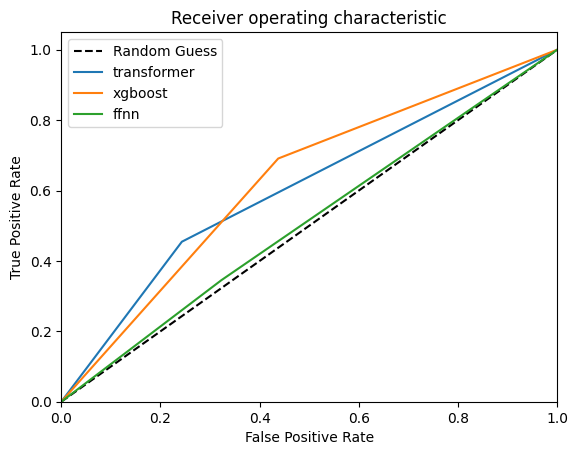

In [10]:
#| label: fig-roc
#| fig-cap: "Receiver operating characteristic"
#| fig-subcap: 
#|   - "Comparison of model ROC"
#| fig-alt:
#|   - "ROC plot of models"
#| layout-ncol: 1

plt.figure()
plt.plot([0,1],[0,1], "k--", label='Random Guess')

for m, df in dfs.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = metrics.roc_curve(df[meta[m]['y_true']], df[meta[m]['y_pred']])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.plot(fpr[1], tpr[1], label=m)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
plt.legend(loc="best")
plt.show()

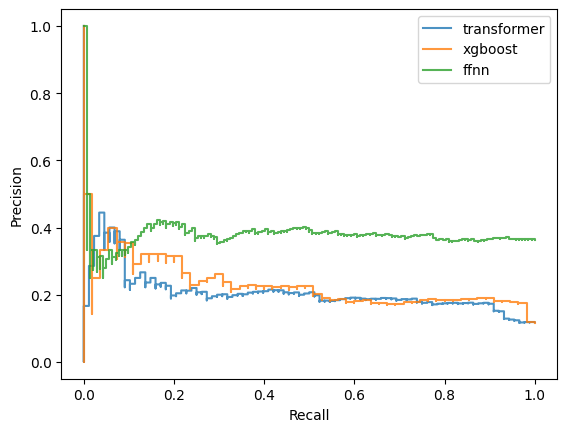

In [11]:
#| label: fig-prc
#| fig-cap: "Precision recall curve"
#| fig-subcap: 
#|   - "Comparison of model precision recall curves"
#| fig-alt:
#|   - "PRC plot of models"
#| layout-ncol: 1

ax = plt.gca()
for m, df in dfs.items():
    precision, recall, threshold = metrics.precision_recall_curve(df[meta[m]['y_true']], 
                                                                  df[meta[m]['y_pred_proba']])
    prd = metrics.PrecisionRecallDisplay(precision, recall)
    prd.plot(ax=ax, alpha=0.8, label=m)
plt.legend(loc="best")
plt.show()